In [1]:
!pip install transformers datasets huggingface-hub[hf-xet] rouge-score

In [2]:
from transformers import (
    BartForConditionalGeneration,
    BartTokenizer,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
import json

# Load dữ liệu
with open("./vietnamese_news_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Chuyển dữ liệu sang dạng HuggingFace Dataset
train_data = [
    {"text": item["text"], "summary": item["summary"]} for item in data
]
dataset = Dataset.from_list(train_data)

# Load tokenizer và model
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)


# Tiền xử lý dữ liệu
def preprocess(example):
    inputs = tokenizer(example["text"], max_length=512, truncation=True, padding="max_length")
    targets = tokenizer(example["summary"], max_length=128, truncation=True, padding="max_length")
    inputs["labels"] = targets["input_ids"]
    return inputs


tokenized_dataset = dataset.map(preprocess, remove_columns=["text", "summary"])

# Thiết lập tham số huấn luyện
training_args = TrainingArguments(
    output_dir="./bart_finetuned",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
    fp16=True,
    report_to="none",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

# Huấn luyện
trainer.train()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss
10,3.206800
20,2.430500
30,1.905800
40,1.556700
50,1.703300
60,1.353300
70,1.423200
80,1.362500
90,1.225900
100,1.071800


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=150, training_loss=1.479524752298991, metrics={'train_runtime': 277.9165, 'train_samples_per_second': 1.079, 'train_steps_per_second': 0.54, 'total_flos': 325065690316800.0, 'train_loss': 1.479524752298991, 'epoch': 3.0})

In [3]:
tokenizer.save_pretrained("./bart_finetuned")
model.save_pretrained("./bart_finetuned")

In [4]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Load lại mô hình và tokenizer đã fine-tune
model_name_or_path = "./bart_finetuned"
tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
model = BartForConditionalGeneration.from_pretrained(model_name_or_path)


def summarize(text, max_length=512, min_length=30):
    inputs = tokenizer(
        [text], max_length=512, truncation=True, return_tensors="pt"
    )
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        min_length=min_length,
        num_beams=4,
        length_penalty=2.0,
        no_repeat_ngram_size=3,
        early_stopping=True,
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


if __name__ == "__main__":
    text = 'Anh nhập Bệnh viện Đa khoa Xuyên Á TP HCM trong vòng 20 phút từ khi xuất hiện triệu chứng. Các bác sĩ ghi nhận bệnh nhân có dấu hiệu điển hình của đột quỵ, bao gồm chóng mặt, run nửa người bên phải, kèm theo huyết áp cao bất thường ở mức 200/100 mmHg. Kết quả chụp MRI xác định nhồi máu tiểu não bên phải. Ngay lập tức, bệnh nhân được kiểm soát huyết áp và tiêm thuốc tiêu sợi huyết (rTPA) qua đường tĩnh mạch. Loại thuốc này giúp tái thông mạch máu bị tắc, đảm bảo cung cấp máu và oxy kịp thời đến các tế bào não, ngăn chặn tổn thương nghiêm trọng. Ngay sau khi tiêm thuốc, tình trạng chóng mặt của bệnh nhân giảm rõ rệt, triệu chứng run cải thiện, có thể giữ thăng bằng khi ngồi và đi lại. Kết quả chụp CT mạch máu não không ghi nhận hẹp hay tắc mạch máu lớn, cho thấy hiệu quả của việc cấp cứu đúng thời điểm. Hiện, anh có thể tự đi lại và vận động bình thường, xuất viện sau 7 ngày điều trị. Bác sĩ Lê Minh Mẫn, Khoa Nội thần kinh, nhấn mạnh tầm quan trọng của việc nhận biết sớm các dấu hiệu đột quỵ để can thiệp kịp thời. Theo quy tắc F.A.S.T, các dấu hiệu điển hình bao gồm méo miệng, liệt tay, nói khó và cần xác định thời gian để đưa bệnh nhân đến bệnh viện sớm nhất. Tuy nhiên, trong một số trường hợp hiếm gặp như bệnh nhân trên, đột quỵ có thể biểu hiện bằng các triệu chứng không điển hình như chóng mặt, choáng váng, mất thăng bằng, mất thị lực, nhìn mờ hoặc nhìn đôi. Vì vậy, quy tắc nhận biết đột quỵ mở rộng là B.E.F.A.S.T (Balance - mất thăng bằng, Eyes - vấn đề thị lực, Face - méo miệng, Arm - liệt tay, Speech - nói khó, Time - thời gian). Bác sĩ Mẫn khuyến cáo khi phát hiện người thân hoặc người xung quanh có dấu hiệu đột quỵ, cần nhanh chóng đưa họ đến cơ sở y tế có trung tâm đột quỵ gần nhất. Tuyệt đối không áp dụng các phương pháp dân gian, vì điều này có thể làm mất "thời gian vàng", dẫn đến hậu quả nghiêm trọng như hôn mê hoặc thậm chí tử vong. Mỹ Ý'
    print("Tóm tắt:", summarize(text))

/usr/local/lib/python3.12/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1733: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Tóm tắt: TP HCM - Chụp MRI xác định nhồi máu tiểu não bên phải, kèm theo huyết áp cao bất thường ở mức 200/100 mmHg.


In [ ]:
# Nén mô hình để tải về
!zip -r bart_finetuned.zip bart_finetuned

  adding: bart_finetuned/ (stored 0%)
  adding: bart_finetuned/checkpoint-100/ (stored 0%)
  adding: bart_finetuned/checkpoint-100/trainer_state.json (deflated 70%)
  adding: bart_finetuned/checkpoint-100/rng_state.pth (deflated 26%)
  adding: bart_finetuned/checkpoint-100/model.safetensors (deflated 7%)
  adding: bart_finetuned/checkpoint-100/training_args.bin (deflated 53%)
  adding: bart_finetuned/checkpoint-100/generation_config.json (deflated 47%)
  adding: bart_finetuned/checkpoint-100/optimizer.pt (deflated 8%)
  adding: bart_finetuned/checkpoint-100/config.json (deflated 62%)
  adding: bart_finetuned/checkpoint-100/scheduler.pt (deflated 61%)
  adding: bart_finetuned/checkpoint-100/scaler.pt (deflated 64%)
  adding: bart_finetuned/checkpoint-150/ (stored 0%)
  adding: bart_finetuned/checkpoint-150/trainer_state.json (deflated 73%)
  adding: bart_finetuned/checkpoint-150/rng_state.pth (deflated 26%)
  adding: bart_finetuned/checkpoint-150/model.safetensors (deflated 7%)
  adding

Device set to use cuda:0


Title: Nam thanh niên đột quỵ khi đang đá bóng
Reference: TP HCM - Chỉ sau 45 phút đá bóng trên sân, nam thanh niên 30 tuổi đột nhiên chóng mặt, mất thăng bằng và ngã gục, bác sĩ chẩn đoán đột quỵ.
Abstractive: TP HCM - Anh nhập bệnh với máu tiểu não bên phải, kèm theo huyết áp cao bất thường ở mức 200/100 mmHg, bao gồm chóng mặt, run nửa đột quỵ, giúp tái thông của chẩn điều trị.
TextRank: Các bác sĩ ghi nhận bệnh nhân có dấu hiệu điển hình của đột quỵ, bao gồm chóng mặt, run nửa người bên phải, kèm theo huyết áp cao bất thường ở mức 200/100 mmHg T, các dấu hiệu điển hình bao gồm méo miệng, liệt tay, nói khó và cần xác định thời gian để đưa bệnh nhân đến bệnh viện sớm nhất Tuy nhiên, trong một số trường hợp hiếm gặp như bệnh nhân trên, đột quỵ có thể biểu hiện bằng các triệu chứng không điển hình như chóng mặt, choáng váng, mất thăng bằng, mất thị lực, nhìn mờ hoặc nhìn đôi
Gemini: Một bệnh nhân đột quỵ đã được đưa đến Bệnh viện Đa khoa Xuyên Á TP HCM chỉ 20 phút sau khi xuất hiện tri

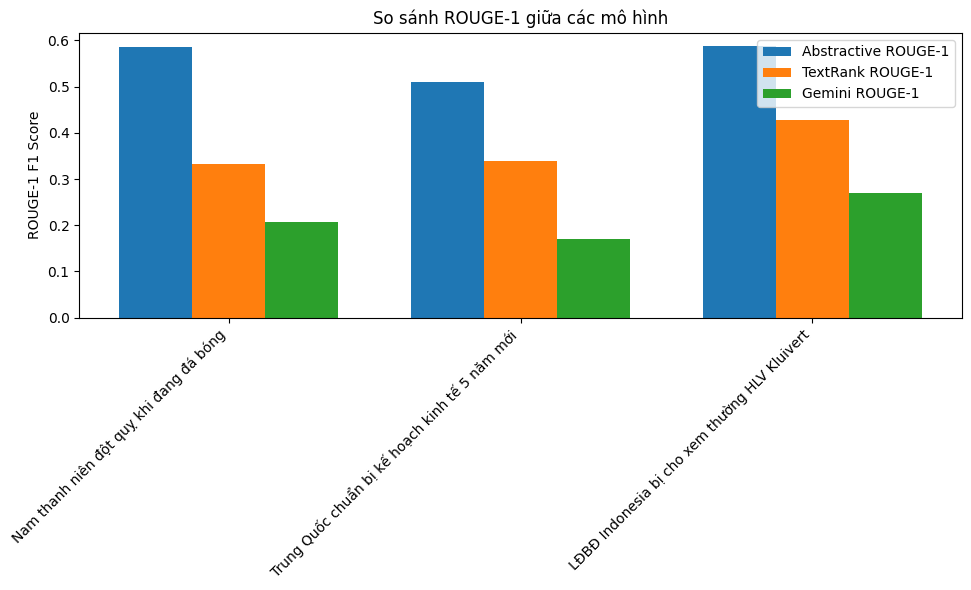

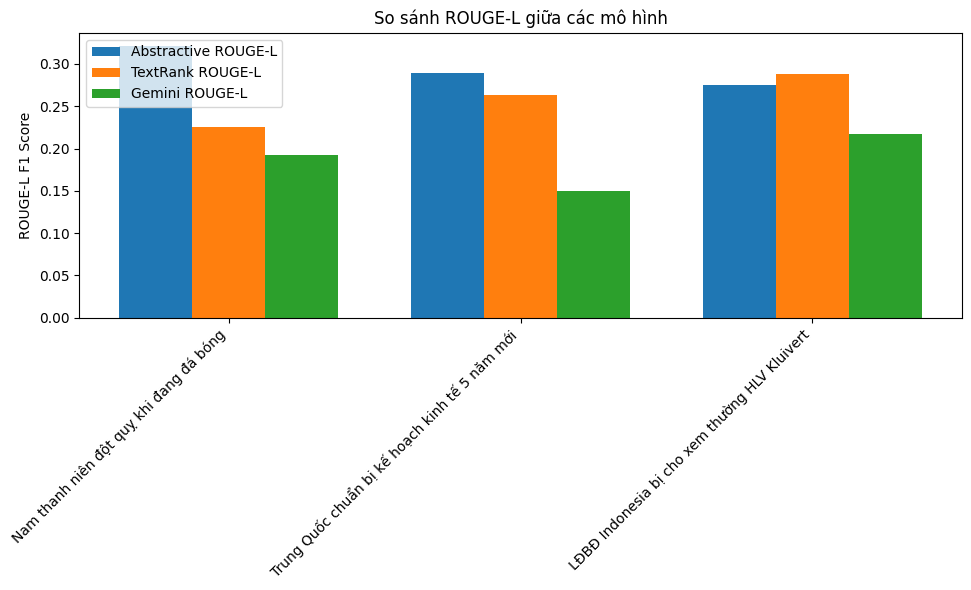

In [ ]:
import json
import time

from google.generativeai.client import configure
from google.generativeai.generative_models import GenerativeModel
from rouge_score import rouge_scorer
import os
import matplotlib.pyplot as plt
import numpy as np


from transformers import pipeline


class AbstractiveSummarizer:
    """
    Tóm tắt văn bản dạng Abstractive sử dụng mô hình Transformer hiện đại (BART)
    """

    def __init__(self, model_name="facebook/bart-large-cnn"):
        self.summarizer = pipeline("summarization", model=model_name)

    def summarize(self, text, max_length=512, min_length=30):
        """
        Tóm tắt văn bản sử dụng mô hình Abstractive

        Args:
            text: Văn bản cần tóm tắt
            max_length: Độ dài tối đa của bản tóm tắt
            min_length: Độ dài tối thiểu của bản tóm tắt

        Returns:
            Bản tóm tắt
        """
        summary = self.summarizer(
            text, max_length=max_length, min_length=min_length, do_sample=False
        )
        return summary[0]["summary_text"]

class TextRankSummarizer:
    """
    Extractive Summarization sử dụng thuật toán TextRank
    Dựa trên PageRank để xếp hạng các câu quan trọng
    """

    def __init__(self, similarity_threshold=0.1):
        self.similarity_threshold = similarity_threshold

    def _build_similarity_matrix(self, sentences):
        """Xây dựng ma trận độ tương đồng giữa các câu"""
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.metrics.pairwise import cosine_similarity
        import numpy as np

        vectorizer = TfidfVectorizer()
        try:
            tfidf_matrix = vectorizer.fit_transform(sentences)
            similarity_matrix = cosine_similarity(tfidf_matrix)
            return similarity_matrix
        except (ValueError, AttributeError):
            n = len(sentences)
            return np.eye(n)

    def _create_graph(self, similarity_matrix):
        """Tạo đồ thị từ ma trận độ tương đồng"""
        import networkx as nx

        graph = nx.Graph()
        n = len(similarity_matrix)

        for i in range(n):
            for j in range(i + 1, n):
                if similarity_matrix[i][j] > self.similarity_threshold:
                    graph.add_edge(i, j, weight=similarity_matrix[i][j])

        return graph

    def summarize(self, text, num_sentences=3, ratio=0.3):
        """
        Tóm tắt văn bản sử dụng TextRank

        Args:
            text: Văn bản cần tóm tắt
            num_sentences: Số câu trong bản tóm tắt
            ratio: Tỷ lệ câu giữ lại (nếu không chỉ định num_sentences)

        Returns:
            Bản tóm tắt
        """
        import re

        def sent_tokenize_simple(text):
            sentences = re.split(r"[.!?]+", text)
            return [s.strip() for s in sentences if s.strip()]

        sentences = sent_tokenize_simple(text)

        if len(sentences) <= num_sentences:
            return " ".join(sentences)

        similarity_matrix = self._build_similarity_matrix(sentences)
        graph = self._create_graph(similarity_matrix)

        import networkx as nx

        try:
            scores = nx.pagerank(graph, max_iter=100)
        except (nx.NetworkXError, nx.PowerIterationFailedConvergence):
            scores = {i: 1.0 / len(sentences) for i in range(len(sentences))}

        ranked_sentences = sorted(
            ((scores.get(i, 0), i, s) for i, s in enumerate(sentences)),
            reverse=True,
        )

        if num_sentences:
            top_sentences = ranked_sentences[:num_sentences]
        else:
            num_to_select = max(1, int(len(sentences) * ratio))
            top_sentences = ranked_sentences[:num_to_select]

        top_sentences = sorted(top_sentences, key=lambda x: x[1])
        summary = " ".join([s[2] for s in top_sentences])
        return summary


# Load dataset
with open("vietnamese_news_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Khởi tạo các mô hình
abstractive = AbstractiveSummarizer(model_name="./bart_finetuned")
textrank = TextRankSummarizer()
configure(api_key="")
gemini = GenerativeModel("gemini-2.5-flash")

scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)


def gemini_summarize(text):
    prompt = f"Tóm tắt văn bản sau bằng tiếng Việt:\n{text}"
    response = gemini.generate_content(prompt)
    return response.text.strip()


results = []
for item in data[:3]:
    text = item.get("text")
    reference = item.get("summary")

    start = time.time()
    if text:
        bart_input = text[:1000]
        abs_sum = abstractive.summarize(bart_input)
    else:
        abs_sum = ""
    abs_time = time.time() - start

    start = time.time()
    textrank_sum = textrank.summarize(text)
    textrank_time = time.time() - start

    start = time.time()
    gemini_sum = gemini_summarize(text)
    gemini_time = time.time() - start

    abs_score = scorer.score(reference, abs_sum)
    textrank_score = scorer.score(reference, textrank_sum)
    gemini_score = scorer.score(reference, gemini_sum)

    results.append(
        {
            "title": item.get("title"),
            "reference": reference,
            "abstractive": abs_sum,
            "textrank": textrank_sum,
            "gemini": gemini_sum,
            "rouge1": {
                "abstractive": abs_score["rouge1"].fmeasure,
                "textrank": textrank_score["rouge1"].fmeasure,
                "gemini": gemini_score["rouge1"].fmeasure,
            },
            "rougeL": {
                "abstractive": abs_score["rougeL"].fmeasure,
                "textrank": textrank_score["rougeL"].fmeasure,
                "gemini": gemini_score["rougeL"].fmeasure,
            },
            "time": {
                "abstractive": abs_time,
                "textrank": textrank_time,
                "gemini": gemini_time,
            },
        }
    )

# In kết quả
for r in results:
    print(f"Title: {r['title']}")
    print(f"Reference: {r['reference']}")
    print(f"Abstractive: {r['abstractive']}")
    print(f"TextRank: {r['textrank']}")
    print(f"Gemini: {r['gemini']}")
    print(f"ROUGE-1: {r['rouge1']}")
    print(f"ROUGE-L: {r['rougeL']}")
    print(f"Time (s): {r['time']}")
    print("-" * 50)

# Chuẩn bị dữ liệu cho biểu đồ
models = ["Abstractive", "TextRank", "Gemini"]
rouge1_scores = [
    [
        r["rouge1"]["abstractive"],
        r["rouge1"]["textrank"],
        r["rouge1"]["gemini"],
    ]
    for r in results
]
rougeL_scores = [
    [
        r["rougeL"]["abstractive"],
        r["rougeL"]["textrank"],
        r["rougeL"]["gemini"],
    ]
    for r in results
]

titles = [
    r["title"] if r["title"] else f"Sample {i+1}"
    for i, r in enumerate(results)
]
x = np.arange(len(titles))  # vị trí các mẫu

width = 0.25  # độ rộng cột

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(
    x - width,
    [score[0] for score in rouge1_scores],
    width,
    label="Abstractive ROUGE-1",
)
rects2 = ax.bar(
    x, [score[1] for score in rouge1_scores], width, label="TextRank ROUGE-1"
)
rects3 = ax.bar(
    x + width,
    [score[2] for score in rouge1_scores],
    width,
    label="Gemini ROUGE-1",
)

ax.set_ylabel("ROUGE-1 F1 Score")
ax.set_title("So sánh ROUGE-1 giữa các mô hình")
ax.set_xticks(x)
ax.set_xticklabels(titles, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()

# Vẽ biểu đồ ROUGE-L
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(
    x - width,
    [score[0] for score in rougeL_scores],
    width,
    label="Abstractive ROUGE-L",
)
rects2 = ax.bar(
    x, [score[1] for score in rougeL_scores], width, label="TextRank ROUGE-L"
)
rects3 = ax.bar(
    x + width,
    [score[2] for score in rougeL_scores],
    width,
    label="Gemini ROUGE-L",
)

ax.set_ylabel("ROUGE-L F1 Score")
ax.set_title("So sánh ROUGE-L giữa các mô hình")
ax.set_xticks(x)
ax.set_xticklabels(titles, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()
